# 10k retrieval filtering, 2-step prediction

> Sample size up to 10k, create two-step prediction chain

In [1]:
#| default_exp experiments.retrieval_filtering

In [210]:
#| export
from typing import Dict, List, Any, Tuple
from pathlib import Path
import os
import re

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics, model_selection

from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableSequence
from langchain.llms import VertexAI
from langchain.vectorstores import Chroma
from langchain.document_loaders import DataFrameLoader
from langchain.output_parsers import CommaSeparatedListOutputParser, RegexParser

from classifier.schema import WRITE_PREFIX, PROJECT_BUCKET, quota_handler
from classifier.load import Email, get_batches, get_emails_from_frame, \
    get_raw_emails, email_small_enough
from classifier.chroma import get_or_make_chroma
from classifier.predict import write_predictions
from classifier.experiments.split_processing import \
    format_email_for_train_summary, \
    format_email_for_test_summary, \
    make_description_from_row, batch_predict, \
    TRAIN_PROMPT, TEST_PROMPT

# GRPC requires this
os.environ["GRPC_DNS_RESOLVER"] = "native"
EXPERIMENT_PREFIX = "retrieval_filtering"
EXPERIMENT_WRITE_PREFIX = WRITE_PREFIX + "/" + EXPERIMENT_PREFIX

In [3]:
data_dir = Path("../../data")
assert data_dir.exists()
experiment_dir = data_dir / EXPERIMENT_PREFIX
if not experiment_dir.exists():
    experiment_dir.mkdir()

Make sure you're authenticated with google cloud before running this notebook.

## Sample

In [4]:
all_emails = get_raw_emails()

In [5]:
size_mask = all_emails.apply(
    lambda row: email_small_enough(
        row.email_subject,
        row.email_body
    ), axis=1)
size_mask.value_counts()

True     56096
False     1141
Name: count, dtype: int64

Filter on size

In [6]:
all_emails_filtered = all_emails[size_mask]
all_emails_filtered.shape[0]

56096

In [7]:
all_emails_filtered.head(2)

,BU,case_number,ACCOUNT_BUSINESS_UNIT__C,received_at,sfdc_category,sfdc_subcategory,predicted_category,predicted_subcategory,record_type,probability,Accuracy_upd,Bin,email_subject,email_body
0,SPD,3469839,NaN,2023-09-11T13:22:32,Order Processing,Order Entry,Order Processing,NaN,2,0.876806,Correct,8,PO# 7004014842 || Walgreens Store 16422 || Ohi...,External Email â€“ Please use caution before o...
2,PD,3469842,a1G4z00000H4uvREAR,2023-09-11T13:22:43,Order Processing,Order Entry,General Inquiry,NaN,1,0.838036,Incorrect,8,Purchase Order #65398,External Email â€“ Please use caution before o...


Train Test Split

In [8]:
train_idx, test_idx = model_selection.train_test_split(
    all_emails_filtered.index.values,
    test_size=2000,
    train_size=8000,
    stratify=all_emails_filtered.sfdc_category)

In [9]:
all_emails_filtered.loc[train_idx, 'sfdc_category'].value_counts().sort_index(),\
all_emails_filtered.loc[test_idx, 'sfdc_category'].value_counts().sort_index()

(sfdc_category
 Account/Inquiry         1712
 Billing / Invoice        316
 Credits                  128
 Delivery                 258
 General Inquiry          770
 Order Discrepancy        552
 Order Processing        3235
 Pricing                   33
 Product Inquiry          426
 Program / Promotions      34
 Returns                  536
 Name: count, dtype: int64,
 sfdc_category
 Account/Inquiry         428
 Billing / Invoice        79
 Credits                  32
 Delivery                 65
 General Inquiry         193
 Order Discrepancy       138
 Order Processing        809
 Pricing                   8
 Product Inquiry         106
 Program / Promotions      8
 Returns                 134
 Name: count, dtype: int64)

In [10]:
# write_idx(
#     pd.Index(train_idx),
#     pd.Index(test_idx),
#     prefix=EXPERIMENT_WRITE_PREFIX
# )

## Process

In [11]:
training_emails = list(get_emails_from_frame(
    get_raw_emails(),
    'train',
    index_prefix=EXPERIMENT_WRITE_PREFIX
))
len(training_emails)

8000

Load label descriptions

In [12]:
descriptions_path = data_dir / 'labels.xlsx'
assert descriptions_path.exists()

In [13]:
descriptions = pd.read_excel(descriptions_path).map(lambda s: s.strip() if isinstance(s, str) else s)
descriptions_dict = descriptions.T.iloc[1:, :].apply(make_description_from_row, axis=1).to_dict()

Process training data

In [14]:
train_processing_chain = TRAIN_PROMPT | VertexAI()

In [15]:
# # Takes about 2.25 hours
# train_summaries = []

# pbar = tqdm(total=len(training_emails), ncols=80, leave=True)

# try:
#     for batch in get_batches(training_emails, 5):
#         batch_prompts = [format_email_for_train_summary(e, descriptions_dict) for e in batch]
#         train_summaries.extend(batch_predict(batch_prompts, train_processing_chain))
#         pbar.update(len(batch))
# except:
#     pass
# finally:
#     pbar.close()

# len(train_summaries) == len(training_emails)

In [16]:
# train_summary_df = pd.DataFrame(
#     zip(
#         train_summaries,
#         [t.idx for t in training_emails],
#         [t.label for t in training_emails]
#     ),
#     columns=['summary', 'idx', 'label']
# )
# train_summary_df.to_csv(
#     f'gs://{PROJECT_BUCKET}/{EXPERIMENT_WRITE_PREFIX}/split_train_summaries.csv', 
#     index=False)

In [17]:
train_summary_df = pd.read_csv(f'gs://{PROJECT_BUCKET}/{EXPERIMENT_WRITE_PREFIX}/split_train_summaries.csv')

In [18]:
train_summary_df.head(2)

,summary,idx,label
0,**Summary**\nThe email is about a new purchas...,40220,Order Processing
1,"**Summary:**\nBarbara Conley, an OS&D Analyst...",19920,Credits


Process test data

In [19]:
test_emails = list(get_emails_from_frame(
    get_raw_emails(),
    'test',
    index_prefix=EXPERIMENT_WRITE_PREFIX
))
len(test_emails)

2000

In [20]:
test_processing_chain = TEST_PROMPT | VertexAI()

In [21]:
# # Takes about ~15 minutes
# test_summaries = []

# pbar = tqdm(total=len(test_emails), ncols=80, leave=True)

# try:
#     for batch in get_batches(test_emails, 5):
#         batch_prompts = [format_email_for_test_summary(e) for e in batch]
#         test_summaries.extend(batch_predict(batch_prompts, test_processing_chain))
#         pbar.update(len(batch))
# except:
#     pass
# finally:
#     pbar.close()

# len(test_summaries) == len(test_emails)

In [22]:
# test_summary_df = pd.DataFrame(
#     zip(
#         test_summaries,
#         [t.idx for t in test_emails],
#         [t.label for t in test_emails]
#     ),
#     columns=['summary', 'idx', 'label']
# )
# test_summary_df.to_csv(
#     f'gs://{PROJECT_BUCKET}/{EXPERIMENT_WRITE_PREFIX}/split_test_summaries.csv', 
#     index=False)

In [23]:
test_summary_df = pd.read_csv(
    f'gs://{PROJECT_BUCKET}/{EXPERIMENT_WRITE_PREFIX}/split_test_summaries.csv'
).dropna(subset=['summary'])
test_summary_df.shape

(1996, 3)

In [24]:
test_summary_df.head(2)

,summary,idx,label
0,A new purchase order (PO) 6600004025 has been...,35311,Order Processing
1,A fax was received from 7183538134 on 10/31/2...,30312,Delivery


## Vectorstore

Add to chroma

In [25]:
chroma_documents = DataFrameLoader(
    train_summary_df,
    page_content_column='summary').load()
len(chroma_documents)

8000

In [26]:
# Should take about 5 minutes initially
chroma = get_or_make_chroma(
    data_dir=experiment_dir,
    documents=chroma_documents
)

## Prediction (2-step)

1. Get initial prediction, "top 3" of available categories, with descriptions

In [27]:
descriptions_path = data_dir / 'labels.xlsx'
assert descriptions_path.exists()

descriptions = pd.read_excel(descriptions_path).map(lambda s: s.strip() if isinstance(s, str) else s)
descriptions_dict = descriptions.T.iloc[1:, :].apply(make_description_from_row, axis=1).to_dict()

In [28]:
len(descriptions_dict)

14

In [125]:
#| export
def make_categories_str(
        category_descriptions: Dict[str, str], 
        ignore: List[str] = [], 
        include: List[str] = []) -> str:
    if len(include) == 0:
        include = list(category_descriptions.keys())
    return "\n".join(
        [f"- {c}" for c, d in category_descriptions.items() \
            if (c not in ignore) and (c in include)]
    )

In [126]:
categories_str = make_categories_str(descriptions_dict)
print(categories_str)

- Account/Inquiry
- Order Processing
- Delivery
- Order Discrepancy
- Returns
- Billing / Invoice
- Credits
- Pricing
- Product Quality
- Product Inquiry
- Claims
- General Inquiry
- IT Customer Technology Issue
- Program / Promotions


In [183]:
#| export
TOP_3_PROMPT_TEMPLATE = """Below is a summary of an email sent to our customer service department. 

-- EMAIL --
{email}
-- END EMAIL --

Here is a list of categories we assign to emails;

-- CATEGORIES --
{categories}
-- END CATEGORIES --

Of the options in the above list, choose the 3 likeliest that describe the following email. 
Only return the categories you choose.
Your response should be a list of comma separated values.

-- TOP 3 LIKELIEST LABELS --
"""

TOP_3_PROMPT = PromptTemplate.from_template(TOP_3_PROMPT_TEMPLATE)

In [184]:
#| export
_LLM = None


def get_llm() -> VertexAI:
    global _LLM
    if _LLM is None:
        _LLM = VertexAI()
    return _LLM


def format_category_answer(answer: List[str]):
    return [s.replace("||","") for s in answer]


def fix_string(string: str) -> str:
    return string.replace("[", "").replace("]","")


def get_top_3_chain() -> RunnableSequence:
    return TOP_3_PROMPT | get_llm() | fix_string | CommaSeparatedListOutputParser() | format_category_answer

In [185]:
step_1_chain = get_top_3_chain()

In [186]:
test_summary = test_summary_df.iloc[0, :].summary

In [192]:
example_step_1_answer = step_1_chain.invoke({
    'categories': categories_str,
    'email': test_summary_df.summary[187]
})
example_step_1_answer

['Product Inquiry', 'General Inquiry', 'IT Customer Technology Issue']

2. Get 3 most similar examples from the top 3 categories from chroma

In [193]:
chroma.similarity_search(
    test_summary, 
    filter={'label': "Order Processing"},
    k=3)

[Document(page_content=' **Summary**\nThe email is about a new purchase order (PO) 6600005050 from CVS Caremark SpecialtyRx.\n\n**Explanation**\n- The subject line of the email indicates that the email is about a new PO from CVS Caremark SpecialtyRx.\n- The body of the email contains the PO number 6600005050.\n- The email is labeled as "Order Processing" because it is about a new order.', metadata={'idx': 47696, 'label': 'Order Processing'}),
 Document(page_content=' **Summary**\nThe email is about a new purchase order (PO) from CVS Caremark SpecialtyRx.\n\n**Explanation**\n- The subject line indicates that the email is about a new PO from CVS Caremark SpecialtyRx.\n- The body of the email contains the PO number, which is 6600002445.\n- The email is labeled as "Order Processing" because it is about a new PO. The label "Order Processing" is used for issues related to order entry, will call, emergency orders, adjusting orders, shipping service changes, canceling orders, and allocation ov

In [194]:
#| export
def get_label_filtered_documents(
        query: str,
        labels: List[str],
        chroma: Chroma,
        k: int = 3
        ) -> Dict[str, List[Document]]:
    documents = {}
    for l in labels:
        label_documents = chroma.similarity_search(
            query,
            filter={'label': l},
            k=k
        )
        documents[l] = label_documents
    return documents

In [195]:
example_filtered_documents = get_label_filtered_documents(
    query=test_summary,
    labels=example_step_1_answer,
    chroma=chroma
)
example_filtered_documents

{'Product Inquiry': [Document(page_content=" **Summary**\nBonnie Brister, a Pharmacy Business Consultant, is requesting that customer service place an order for one unit of CIN #5049549 for an unnamed customer.\n\n**Explanation**\n- The subject line includes the customer's name and a reference number, indicating that this is a specific customer inquiry.\n- The body of the email provides the customer's CIN number and the quantity they want to order.\n- The email is from a Pharmacy Business Consultant, who is likely authorized to place orders on behalf of customers.\n- The email does not mention any issues or problems, so it is", metadata={'idx': 40467, 'label': 'Product Inquiry'}),
  Document(page_content=' **Summary**\nLogan Sawano, a Pharmacy Procurement Specialist at University of Colorado Hospital, sent an email to customer service requesting to add Diclofenac 1% topical gel to a backorder list for account number 2150403285. The requested quantity is 70 tubes, which is the outstandi

3. Get final prediction

In [196]:
#| export
# categories is a list like;
# 0. CATEGORY
# 1. CATEGORY 2
# 2. CATEGORY 3
PREDICTION_TEMPLATE = """Below is a summary of an email sent to our customer service department.
It is your job to decide which category the email belongs to.

-- EMAIL --
{email}
-- END EMAIL --

Choose which of the following categories the email above belongs to;

-- CATEGORIES --
{categories}
-- END CATEGORIES --

Here are some similar emails and how they were labeled to help you decide.

-- EXAMPLES --
{examples}
-- END EXAMPLES --

Return only the number of the category you have picked.

Category Number: """

PREDICTION_PROMPT = PromptTemplate.from_template(PREDICTION_TEMPLATE)

In [197]:
#| export
FINAL_REGEX = "(\d+)(?!.*\d)"

In [198]:
#| export
def get_prediction_chain() -> RunnableSequence:
    return PREDICTION_PROMPT | get_llm() | RegexParser(
        regex=FINAL_REGEX, 
        output_keys=['result'], 
        default_output_key='result')

In [199]:
prediction_chain = get_prediction_chain()

In [200]:
#| export
def format_filtered_examples(examples: Dict[str, List[Document]]) -> str:
    result = ""
    for cat, docs in examples.items():
        cat_header = f"||{cat}|| examples;"
        document_content = "\n".join(
            [
                f"Summary: {d.page_content}\nLabel: {d.metadata.get('label')}\n" for d in docs
            ])
        result = result + cat_header + document_content
    return result

In [201]:
#| export
def format_final_category_string(categories: List[str]) -> str:
    return "\n".join([f'{i}. {cat}' for i, cat in enumerate(categories)])

In [202]:
example_prediction = prediction_chain.invoke({
    'categories': format_final_category_string(example_step_1_answer),
    'examples': format_filtered_examples(example_filtered_documents),
    'email': test_summary
})
example_prediction

{'result': '1'}

In [203]:
#| export
@quota_handler
def invoke_chain(chain: RunnableSequence, *args, **kwargs) -> Any:
    return chain.invoke(*args, **kwargs)

In [211]:
#| export
def get_summary_prediction(
        summary: str, 
        chroma: Chroma, 
        step_1_chain: RunnableSequence,
        step_2_chain: RunnableSequence,
        descriptions: Dict[str, str]) -> Tuple[List[str], List[Document], int, str]:
    step_1_answer = None
    similar_documents = None
    step_1_answer_position = None
    final_answer = None
    if summary is None:
        return step_1_answer, similar_documents, step_1_answer_position, final_answer
    categories_str = make_categories_str(descriptions)
    # Make a prediction for an input summary
    step_1_answer = invoke_chain(
        step_1_chain, 
        {
            'categories': categories_str,
            'email': summary
        })
    # I've run out of time to tinker with this. If it ain't right, ignore it.
    # TODO: Fix step one prompt / chain to handle outlier inference cases that aren't formatted right.
    if len(step_1_answer) != 3:
        return step_1_answer, similar_documents, step_1_answer_position, final_answer
    # Get similar documents for each likely category
    similar_documents = get_label_filtered_documents(
        query=summary,
        labels=step_1_answer,
        chroma=chroma
    )
    step_2_answer = invoke_chain(
        step_2_chain,
        {
            'categories': format_final_category_string(step_1_answer),
            'examples': format_filtered_examples(similar_documents),
            'email': summary
        })
    step_1_answer_position = int(step_2_answer.get('result'))
    if step_1_answer_position > len(step_1_answer):
        return step_1_answer, similar_documents, step_1_answer_position, final_answer
    try:
        final_answer = step_1_answer[step_1_answer_position].strip()
    except IndexError as e:
        print("Position was ", step_1_answer_position)
        print("List was ", step_1_answer)
        raise e
    return step_1_answer, similar_documents, step_1_answer_position, final_answer

In [212]:
## For Debugging
# get_summary_prediction(test_summary_df.iloc[15, :].summary, chroma,
#                        step_1_chain, prediction_chain, descriptions_dict)

### Issues identified and attempted to solve;

1. Issues being picked in step one that aren't in the given list
2. Parsing the issues in step one into a list of strings
3. Final predictions not belonging to the set of categories to pick
4. Including descriptions doesn't work well in inference.
5. Selected category positions being greater than 2.

### Lessons learned

1. Multi-class classification isn't really handled well without a lot of wrangling of the LLM. Should probably re-phrase the task into a binary classification or re-think the classes so that there aren't so many.
2. Maybe LLM should only try to identify the most prevalent class as a binary classification? Or provide value in some other way for this task?

In [213]:
test_predictions = []

for s in tqdm(test_summary_df.summary[:500], ncols=80, leave=True):
    summary_prediction = get_summary_prediction(
        summary=s,
        chroma=chroma,
        step_1_chain=step_1_chain,
        step_2_chain=prediction_chain,
        descriptions=descriptions_dict
    )
    test_predictions.append(summary_prediction)

100%|█████████████████████████████████████████| 500/500 [27:16<00:00,  3.27s/it]


## Evaluation

In [214]:
# Remove bad predictions
test_predictions_df = pd.DataFrame(
    test_predictions,
    columns=['step1', 'step1_documents', 'step2', 'prediction']
)
test_predictions_df.head()

,step1,step1_documents,step2,prediction
0,"[Order Processing, Account/Inquiry, Billing / ...",{'Order Processing': [page_content=' **Summary...,0.0,Order Processing
1,"[General Inquiry, Product Inquiry, IT Customer...",{'General Inquiry': [page_content=' The email ...,0.0,General Inquiry
2,"[Order Processing, Order Discrepancy, Product ...",{'Order Processing': [page_content=' **Summary...,0.0,Order Processing
3,"[Billing / Invoice, Credits, Account/Inquiry]",{'Billing / Invoice': [page_content=' The emai...,0.0,Billing / Invoice
4,"[Order Processing, Delivery, Product Inquiry]",{'Order Processing': [page_content=' **Summary...,0.0,Order Processing


In [218]:
test_predictions_df.isna().sum()

step1              0
step1_documents    7
step2              7
prediction         7
dtype: int64

In [228]:
bad_step1_mask = test_predictions_df.step1_documents.isna()
bad_prediction_mask = ~test_predictions_df.prediction.isin(descriptions_dict.keys())
test_predictions_df[bad_step1_mask].step1.iloc[0:4]

37     [General Inquiry,Product Inquiry,IT Customer T...
105                [General Inquiry,Product Inquiry,Fax]
242                     [Product Quality,Returns,Claims]
246             [Product Quality,Claims,General Inquiry]
Name: step1, dtype: object

In [229]:
evaluation_predictions_df = test_predictions_df[
    ~bad_step1_mask & \
    ~bad_prediction_mask
]
evaluation_predictions_df.head()

,step1,step1_documents,step2,prediction
0,"[Order Processing, Account/Inquiry, Billing / ...",{'Order Processing': [page_content=' **Summary...,0.0,Order Processing
1,"[General Inquiry, Product Inquiry, IT Customer...",{'General Inquiry': [page_content=' The email ...,0.0,General Inquiry
2,"[Order Processing, Order Discrepancy, Product ...",{'Order Processing': [page_content=' **Summary...,0.0,Order Processing
3,"[Billing / Invoice, Credits, Account/Inquiry]",{'Billing / Invoice': [page_content=' The emai...,0.0,Billing / Invoice
4,"[Order Processing, Delivery, Product Inquiry]",{'Order Processing': [page_content=' **Summary...,0.0,Order Processing


In [230]:
pred_kwargs = {
    'y_true': test_summary_df.iloc[evaluation_predictions_df.index.values, :].label.tolist(),
    'y_pred': evaluation_predictions_df.prediction
}

In [231]:
metrics.accuracy_score(**pred_kwargs)

0.4742729306487696

In [232]:
print(metrics.classification_report(**pred_kwargs, zero_division=np.nan))

                              precision    recall  f1-score   support

             Account/Inquiry       0.43      0.13      0.20        95
           Billing / Invoice       0.08      0.88      0.15         8
                      Claims       0.00       nan       nan         0
                     Credits       0.15      0.33      0.21         6
                    Delivery       0.17      0.30      0.21        20
             General Inquiry       0.23      0.06      0.10        50
IT Customer Technology Issue       0.00       nan       nan         0
           Order Discrepancy       0.46      0.76      0.58        25
            Order Processing       0.80      0.76      0.78       190
                     Pricing       1.00      0.25      0.40         4
             Product Inquiry       0.46      0.30      0.36        20
             Product Quality       0.00       nan       nan         0
        Program / Promotions       0.00      0.00       nan         1
                   

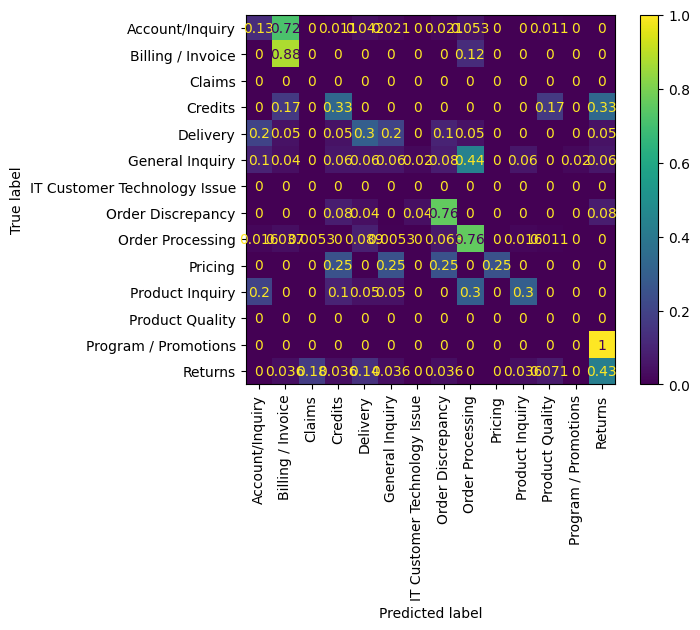

In [233]:
metrics.ConfusionMatrixDisplay.from_predictions(
    normalize='true',
    xticks_rotation='vertical',
    **pred_kwargs
)

## Export

In [234]:
#| hide
import nbdev; nbdev.nbdev_export()